## Weather Forecasting

### Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
logging.disable(logging.CRITICAL)
%matplotlib inline

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load Dataset
df = pd.read_csv('changi_climate.csv')

# Preview Dataset
display(df.tail())
display(df.info())

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
3282,Changi,2022,12,27,0.0,0.0,0.0,0.0,27.4,30.4,25.8,14.0,37
3283,Changi,2022,12,28,0.2,0.2,0.2,0.2,26.8,30.1,25.3,10.9,33.3
3284,Changi,2022,12,29,15.8,11.0,11.4,15.8,26.3,30.3,23.1,10.4,33.3
3285,Changi,2022,12,30,0.0,0.0,0.0,0.0,27.2,31.1,25.0,10.5,33.3
3286,Changi,2022,12,31,0.0,0.0,0.0,0.0,27.4,31.3,24.6,11.3,42.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Station                        3287 non-null   object 
 1   Year                           3287 non-null   int64  
 2   Month                          3287 non-null   int64  
 3   Day                            3287 non-null   int64  
 4   Daily Rainfall Total (mm)      3287 non-null   float64
 5   Highest 30 min Rainfall (mm)   3282 non-null   float64
 6   Highest 60 min Rainfall (mm)   3280 non-null   float64
 7   Highest 120 min Rainfall (mm)  3280 non-null   float64
 8   Mean Temperature (°C)          3256 non-null   float64
 9   Maximum Temperature (°C)       3256 non-null   float64
 10  Minimum Temperature (°C)       3256 non-null   float64
 11  Mean Wind Speed (km/h)         3281 non-null   float64
 12  Max Wind Speed (km/h)          3275 non-null   o

None

**Data Summary**
- 3287 rows
- 13 features
- Most features has some missing values
- Target: Forecast Mean Temperature

### Exploratory Data Analysis

**Descriptive Statistics**

In [3]:
# Summarise statistics
df.describe()

,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h)
count,3287.000000,3287.000000,3287.000000,3287.000000,3282.000000,3280.000000,3280.000000,3256.000000,3256.000000,3256.000000,3281.000000
mean,2018.000000,6.523274,15.728628,5.109827,3.012523,3.712713,4.209787,28.053716,31.714220,25.480713,8.883968
std,2.582067,3.449133,8.801004,12.207943,6.460285,8.223056,9.406909,1.101396,1.497653,1.312851,3.032408
min,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,23.000000,23.700000,21.100000,0.400000
25%,2016.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,27.300000,31.000000,24.600000,6.500000
50%,2018.000000,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,28.100000,32.000000,25.500000,8.300000
75%,2020.000000,10.000000,23.000000,3.800000,2.400000,2.850000,3.400000,28.900000,32.700000,26.400000,11.000000
max,2022.000000,12.000000,31.000000,210.600000,53.400000,73.800000,85.600000,30.700000,35.400000,28.600000,21.400000


In [4]:
# Add date to dataframe
df['Year'] = df['Year'].astype(str)
df['Month'] = df['Month'].astype(str)
df['Day'] = df['Day'].astype(str)

df['date'] = df['Year'].str.cat([df['Month'], df['Day']], sep='-')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Drop irrelevant columns
df.drop(columns=['Station', 'Highest 30 min Rainfall (mm)', 'Highest 60 min Rainfall (mm)',
                 'Highest 120 min Rainfall (mm)', 'Maximum Temperature (°C)', 'Minimum Temperature (°C)', 
                 'Max Wind Speed (km/h)'], inplace=True)

# View current dataframe
df.head()

,Year,Month,Day,Daily Rainfall Total (mm),Mean Temperature (°C),Mean Wind Speed (km/h),date
0,2014,1,1,0.0,26.7,10.0,2014-01-01
1,2014,1,2,0.0,27.4,11.9,2014-01-02
2,2014,1,3,0.0,27.1,9.7,2014-01-03
3,2014,1,4,0.0,27.1,6.4,2014-01-04
4,2014,1,5,18.4,24.8,6.8,2014-01-05


**Mean Temperature over the years**

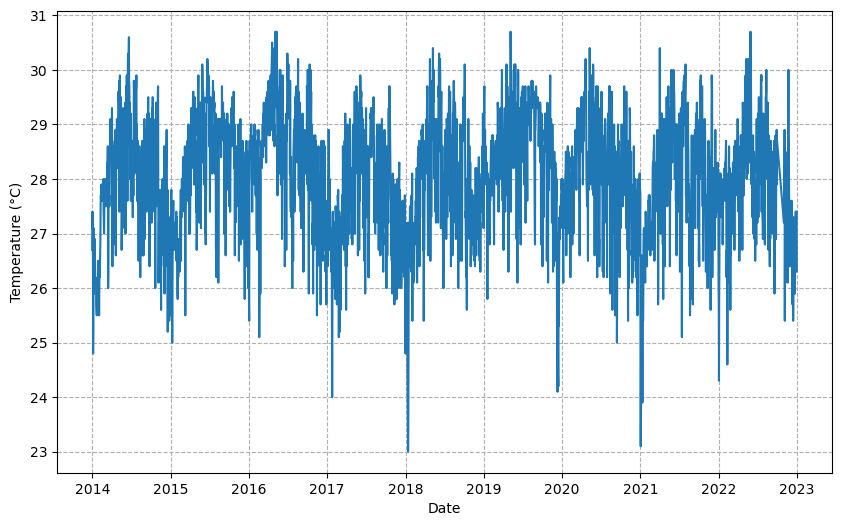

In [5]:
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='Mean Temperature (°C)', data=df)
plt.grid(True, which='major', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

- Temperature follows a cyclic pattern, with a gradual increase from the beginning of the year, reaching its highest point around the middle of the year, and then gradually decreasing during the second half of the year.

**Daily Rainfall over the years**

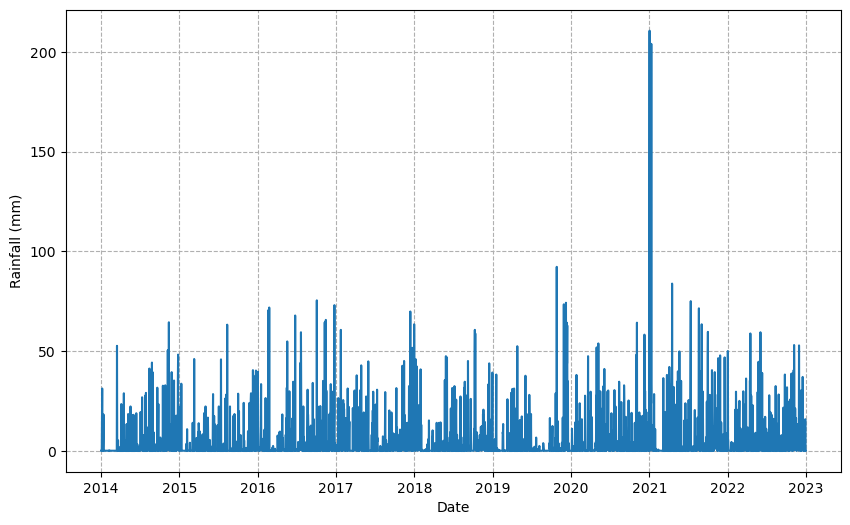

In [6]:
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='Daily Rainfall Total (mm)', data=df)
plt.grid(True, which='major', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.show()

- Rainfall exhibits a relatively unpredictable pattern. While some years indicate an increasing trend in rainfall as the year progresses, there is an overall randomness to its distribution.

**Mean Windspeed over the years**

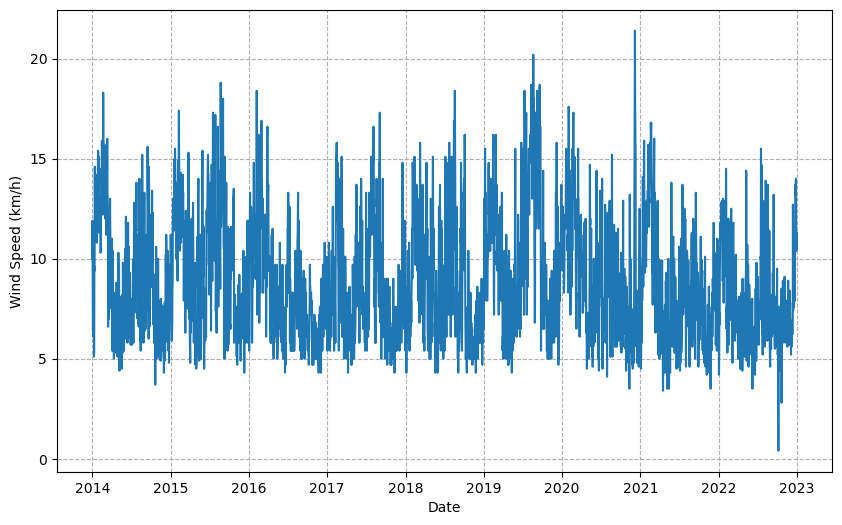

In [7]:
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='Mean Wind Speed (km/h)', data=df)
plt.grid(True, which='major', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Wind Speed (km/h)')
plt.show()

- Wind speed displays a cyclic pattern, with speeds increasing both at the start of a year and following the midpoint of the year, and decreases towards the midpoint and end of the year.

**Correlation Heatmap**

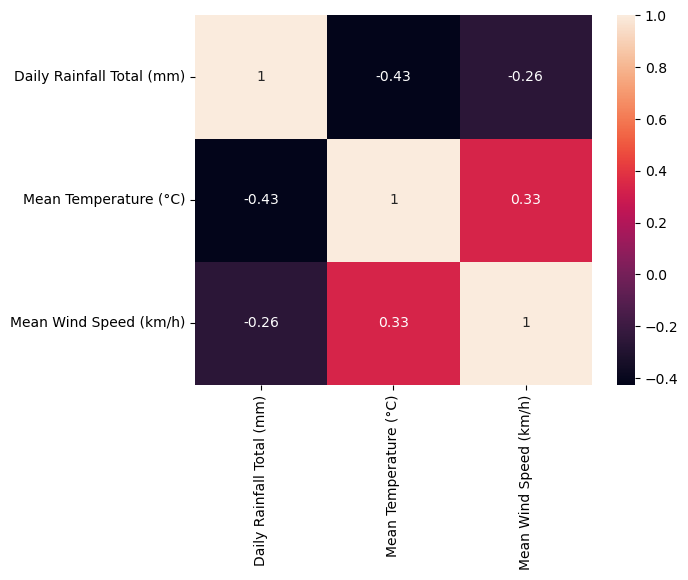

In [8]:
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)
plt.show()

- Moderate negative correlation between Mean Temperature and Daily Rainfall (Higher temperatures are associated with lower daily rainfall).
- Weak positive correlation between Mean Temperature and Mean Wind Speed (Higher temperatures are assoicated with higher wind speeds).

**Yearly Temperature Change**

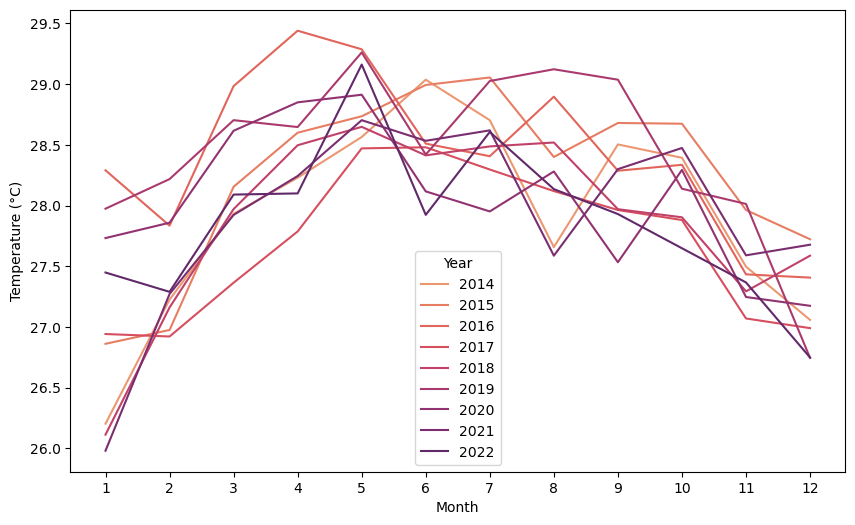

In [9]:
plt.figure(figsize=(10,6))
sns.set_palette('magma')
sns.lineplot(x='Month', y='Mean Temperature (°C)', data=df, hue='Year', palette='flare', errorbar=None)
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.show()

### Forecasting Weather

**Modeling**

In [10]:
# Update column names
df = df.rename(columns={'date': 'ds', 'Mean Temperature (°C)': 'y'})

# Forward fill missing values
df['y'].fillna(method='ffill', inplace=True)

# Split Data
train_df = df[df['ds'] < '2022-01-01']
test_df = df[df['ds'] >= '2022-01-01']

# Train model
model = Prophet()
model.fit(train_df)

# Make Predictions
future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

**Plot Results**

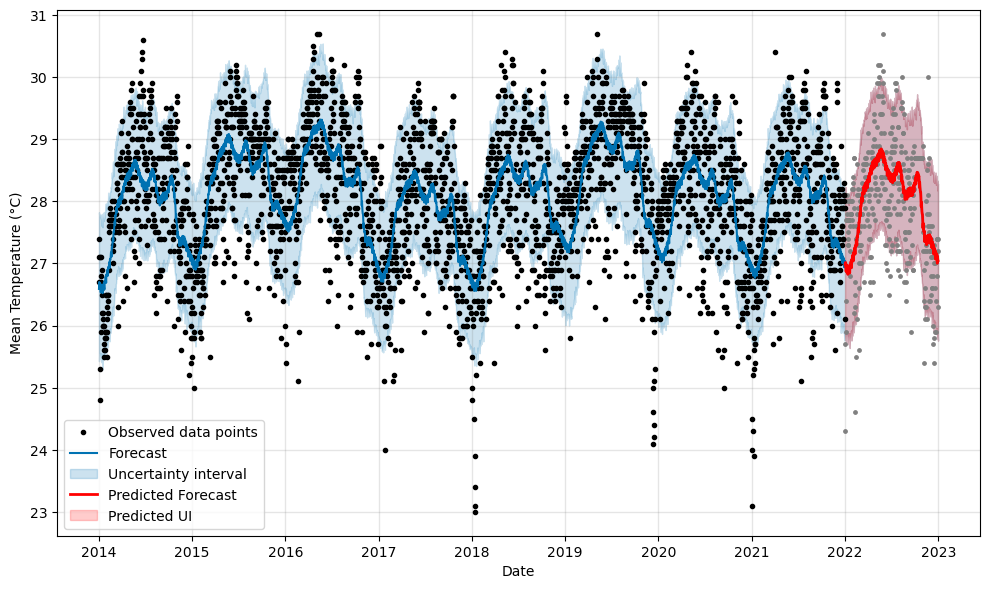

In [11]:
fig = model.plot(forecast)

# Filter the forecast and uncertainty interval for 2022 to 2023
test_forecast = forecast[forecast['ds'].between('2022-01-01', '2023-12-31')]

# Highlight the forecast and uncertainty interval for 2022 to 2023 in red
plt.plot(test_forecast['ds'], test_forecast['yhat'], color='red', 
         label='Predicted Forecast', linewidth=2)
plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], 
                 test_forecast['yhat_upper'], color='red', label='Predicted UI', alpha=0.2)

# Scatter plot for actual test data points
plt.scatter(test_df['ds'], test_df['y'], color='grey', s=6)

plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

**Evaluation**

In [12]:
# Calculate MAE and RMSE
mae = mean_absolute_error(test_df['y'], forecast['yhat'][-len(test_df):])
rmse = mean_squared_error(test_df['y'], forecast['yhat'][-len(test_df):], squared=False)

# Print Metrics
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")

Mean Absolute Error: 0.678
Root Mean Squared Error: 0.845


- Mean Absolute Error of 0.678 indicates that the forecasted values differ by 0.678°C on average from the actual observed values.
- Model performed relatively well, as the daily forecasted temperature would averagely differ by less than a degree celcius.